### **Data Preprocessing and Feature Engineering**

Here, we will do:

- Create new features that may have predictive power
- Convert categorical variables to numerical variables, using encoding techniques
- Scale or normalize numeric variables if necessary
- Split the data into training and testing subsets
- Remove ireelevant features

We begin by converting nested values from string formats to list/dictionaries using literal_eval function.

In [1]:
#import Packages
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from tqdm import tqdm
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, StratifiedKFold, GridSearchCV


import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import dataset 
df = pd.read_excel('Dataset.xlsx')

In [3]:
# List nested columns
nested_columns = [
    'PurchaseHistory',
    'SubscriptionDetails',
    'PaymentHistory',
    'WebsiteUsage',
    'ClickstreamData',
    'EngagementMetrics',
    'Feedback',
    'MarketingCommunication',
    'ServiceInteractions'
]

# Apply the literal_eval function
for feature in nested_columns:
    df[feature] = df[feature].apply(
        lambda x: literal_eval(x) if isinstance(x, str) else x
    )

More features will be extracted from the dataset

In [4]:
# PurchaseHistory
df['PurchaseProducts'] = df['PurchaseHistory'].apply(lambda x: '|'.join([i['Product'] for i in x]))
df['PurchaseFrequency'] = df['PurchaseHistory'].apply(lambda x: sum([i['Frequency'] for i in x]))
df['PurchaseValue'] = df['PurchaseHistory'].apply(lambda x: sum([i['Value'] for i in x]))

# SubscriptionDetails
df['SubscriptionPlan'] = df['SubscriptionDetails'].apply(lambda x: x['Plan'])
df['SubscriptionStartDate'] = pd.to_datetime(df['SubscriptionDetails'].apply(lambda x: x['Start_Date']))
df['SubscriptionEndDate'] = pd.to_datetime(df['SubscriptionDetails'].apply(lambda x: x['End_Date']))
df['SubscriptionDuration'] = (df['SubscriptionEndDate'] - df['SubscriptionStartDate']).dt.days

# WebsiteUsage
df['WebsitePageViews'] = df['WebsiteUsage'].apply(lambda x: x['PageViews'])
df['WebsiteTimeSpent'] = df['WebsiteUsage'].apply(lambda x: x['TimeSpent(minutes)'])

# EngagementMetrics
df['EngagementMetricsLogins'] = df['EngagementMetrics'].apply(lambda x: x['Logins'])
df['EngagementMetricsFrequency'] = df['EngagementMetrics'].apply(lambda x: x['Frequency'])

# Feedback
df['FeedbackRating'] = df['Feedback'].apply(lambda x: x['Rating'])  
df['FeedbackComment'] = df['Feedback'].apply(lambda x: x['Comment'])   

# MarketingCommunication
df['MarketingCommunicationNoOfEmails'] = df['MarketingCommunication'].apply(lambda x: len(x))  
df['MarketingCommunicationOpenClickDiff'] = df['MarketingCommunication'].apply(
    lambda x: np.mean([
        (pd.to_datetime(i['Email_Clicked']) \
            - pd.to_datetime(i['Email_Opened'])).days for i in x
    ])
)
df['MarketingCommunicationSentOpenDiff'] = df['MarketingCommunication'].apply(
    lambda x: np.mean([
        (pd.to_datetime(i['Email_Opened']) \
            - pd.to_datetime(i['Email_Sent'])).days for i in x
    ])
)                                            


Special extraction from 3 columns:
- 'ServiceInteractions'
- 'PaymentHistory'
- 'ClickstreamData'

Check for the unique parameters/values in these columns

In [5]:
# Get all unique 'ServiceInteraction' types
service_interaction_types = df['ServiceInteractions'].apply(lambda x: list(set([i['Type'] for i in x])))
service_interaction_types = service_interaction_types.to_list()
unique_service_interaction_types = []
for i in service_interaction_types:
    unique_service_interaction_types.extend(i)
unique_service_interaction_types = list(set(unique_service_interaction_types))
print("Unique Service Interaction Types:", unique_service_interaction_types)

# Get all unique 'PaymentHistory' Methods
payment_history_methods = df['PaymentHistory'].apply(lambda x: list(set([i['Method'] for i in x])))
payment_history_methods = payment_history_methods.to_list()
unique_payment_history_methods = []
for i in payment_history_methods:
    unique_payment_history_methods.extend(i)
unique_payment_history_methods = list(set(unique_payment_history_methods))
print("Unique Payment History Methods:", unique_payment_history_methods)

# Get all unique 'ClickstreamData' action
clickstream_data_actions = df['ClickstreamData'].apply(lambda x: list(set([i['Action'] for i in x])))
clickstream_data_actions = clickstream_data_actions.to_list()
unique_clickstream_data_actions = []
for i in clickstream_data_actions:
    unique_clickstream_data_actions.extend(i)
unique_clickstream_data_actions = list(set(unique_clickstream_data_actions))
print("Unique Clickstream Data Actions:", unique_clickstream_data_actions)

Unique Service Interaction Types: ['Chat', 'Call', 'Email']
Unique Payment History Methods: ['Bank Transfer', 'Credit Card', 'PayPal']
Unique Clickstream Data Actions: ['Search', 'Add to Cart', 'Click']


From these 3 columns, we will be encoding more

In [6]:
# ServiceInteractions 
for usit in unique_service_interaction_types:
    df[f'ServiceInteractions_{usit}'] = df['ServiceInteractions'].apply(
        lambda x: sum([1 for i in x if i['Type'] == usit])
    )
# First and last interaction dates
df['FirstInteractionDate'] = df['ServiceInteractions'].apply(
    lambda x: min(i['Date'] for i in x) if x else None
)

df['LastInteractionDate'] = df['ServiceInteractions'].apply(
    lambda x: max(i['Date'] for i in x) if x else None
)
    
# PaymentHistory
df['PaymentHistoryNoOfLatePayments'] = df['PaymentHistory'].apply(
    lambda x: sum(i['Late_Payments'] for i in x))
df['PaymentHistoryAvgNoOfLatePayments'] = df['PaymentHistory'].apply(
    lambda x: np.mean([i['Late_Payments'] for i in x])
)

# ClickstreamData
for ucda in unique_clickstream_data_actions:
    df[f'ClickstreamData_{ucda}'] = df['ClickstreamData'].apply(
        lambda x: len([i for i in x if i['Action'] == ucda])
    )

View a subset of the new data

In [7]:
df.columns

Index(['CustomerID', 'Name', 'Age', 'Gender', 'Location', 'Email', 'Phone',
       'Address', 'Segment', 'PurchaseHistory', 'SubscriptionDetails',
       'ServiceInteractions', 'PaymentHistory', 'WebsiteUsage',
       'ClickstreamData', 'EngagementMetrics', 'Feedback',
       'MarketingCommunication', 'NPS', 'ChurnLabel', 'Timestamp',
       'PurchaseProducts', 'PurchaseFrequency', 'PurchaseValue',
       'SubscriptionPlan', 'SubscriptionStartDate', 'SubscriptionEndDate',
       'SubscriptionDuration', 'WebsitePageViews', 'WebsiteTimeSpent',
       'EngagementMetricsLogins', 'EngagementMetricsFrequency',
       'FeedbackRating', 'FeedbackComment', 'MarketingCommunicationNoOfEmails',
       'MarketingCommunicationOpenClickDiff',
       'MarketingCommunicationSentOpenDiff', 'ServiceInteractions_Chat',
       'ServiceInteractions_Call', 'ServiceInteractions_Email',
       'FirstInteractionDate', 'LastInteractionDate',
       'PaymentHistoryNoOfLatePayments', 'PaymentHistoryAvgNoOfLatePaym

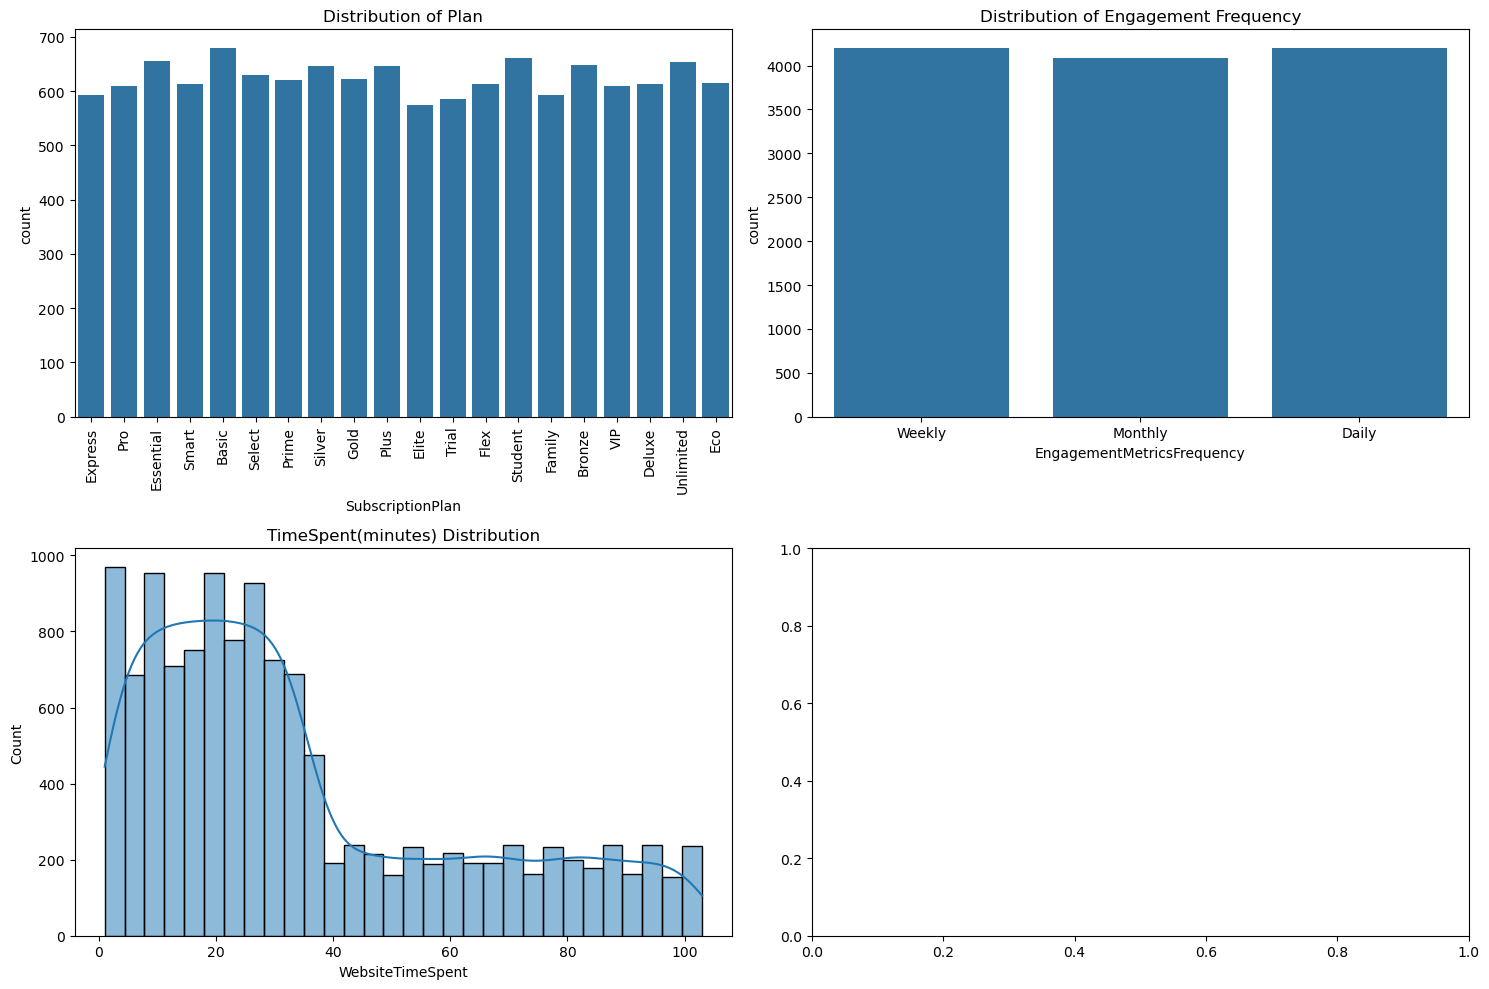

In [8]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# Plot 1: Time Spent Distribution
sns.histplot(df['WebsiteTimeSpent'], bins=30, kde=True, ax=ax[1, 0])
ax[1, 0].set_title('TimeSpent(minutes) Distribution')

# Plot 2: Distribution of Plan
sns.countplot(x='SubscriptionPlan', data=df, ax=ax[0, 0])
ax[0, 0].set_title('Distribution of Plan')
ax[0, 0].tick_params(axis='x', rotation=90)

# Plot 3: Distribution of Gender
sns.countplot(x='EngagementMetricsFrequency', data=df, ax=ax[0, 1])
ax[0, 1].set_title('Distribution of Engagement Frequency')

# Adjust layout and show plot
plt.tight_layout()
plt.show();

Pick out necessary columns

In [9]:
df_ = df[[
    'Age',
    'Gender',
    'NPS',
    'ChurnLabel',
    'PurchaseFrequency',
    'PurchaseValue',
    'SubscriptionPlan',
    'WebsitePageViews',
    'WebsiteTimeSpent',
    'EngagementMetricsLogins',
    'EngagementMetricsFrequency',
    'FeedbackRating',
    'MarketingCommunicationNoOfEmails',
    'MarketingCommunicationOpenClickDiff',
    'MarketingCommunicationSentOpenDiff',
    'ServiceInteractions_Call',
    'ServiceInteractions_Email',
    'ServiceInteractions_Chat',
    'PaymentHistoryNoOfLatePayments',
    'ClickstreamData_Click',
    'ClickstreamData_Add to Cart',
    'ClickstreamData_Search',
    'SubscriptionDuration',
    'FirstInteractionDate',
    'LastInteractionDate'
]]

df_.head()

,Age,Gender,NPS,ChurnLabel,PurchaseFrequency,PurchaseValue,SubscriptionPlan,WebsitePageViews,WebsiteTimeSpent,EngagementMetricsLogins,...,ServiceInteractions_Call,ServiceInteractions_Email,ServiceInteractions_Chat,PaymentHistoryNoOfLatePayments,ClickstreamData_Click,ClickstreamData_Add to Cart,ClickstreamData_Search,SubscriptionDuration,FirstInteractionDate,LastInteractionDate
0,31,Male,3,1,38,3994.72,Express,49,15,19,...,1,1,2,40,4,8,12,871,2019-09-26,2021-07-25
1,66,Female,6,0,4,2844.35,Pro,100,9,9,...,5,10,4,10,9,8,7,290,2019-01-12,2022-12-13
2,36,Female,3,0,14,1866.52,Essential,1,97,19,...,1,1,1,8,3,2,7,319,2019-10-09,2022-01-04
3,62,Female,1,1,28,1378.64,Smart,25,31,4,...,17,18,24,79,16,15,16,803,2019-01-03,2022-11-10
4,68,Female,3,0,39,2425.05,Basic,77,51,12,...,4,5,1,2,9,17,4,580,2019-04-10,2022-12-19


In [10]:
df_.columns

Index(['Age', 'Gender', 'NPS', 'ChurnLabel', 'PurchaseFrequency',
       'PurchaseValue', 'SubscriptionPlan', 'WebsitePageViews',
       'WebsiteTimeSpent', 'EngagementMetricsLogins',
       'EngagementMetricsFrequency', 'FeedbackRating',
       'MarketingCommunicationNoOfEmails',
       'MarketingCommunicationOpenClickDiff',
       'MarketingCommunicationSentOpenDiff', 'ServiceInteractions_Call',
       'ServiceInteractions_Email', 'ServiceInteractions_Chat',
       'PaymentHistoryNoOfLatePayments', 'ClickstreamData_Click',
       'ClickstreamData_Add to Cart', 'ClickstreamData_Search',
       'SubscriptionDuration', 'FirstInteractionDate', 'LastInteractionDate'],
      dtype='object')

In [11]:
df_.loc[0]

Age                                            31
Gender                                       Male
NPS                                             3
ChurnLabel                                      1
PurchaseFrequency                              38
PurchaseValue                             3994.72
SubscriptionPlan                          Express
WebsitePageViews                               49
WebsiteTimeSpent                               15
EngagementMetricsLogins                        19
EngagementMetricsFrequency                 Weekly
FeedbackRating                                  1
MarketingCommunicationNoOfEmails                8
MarketingCommunicationOpenClickDiff         319.0
MarketingCommunicationSentOpenDiff          818.0
ServiceInteractions_Call                        1
ServiceInteractions_Email                       1
ServiceInteractions_Chat                        2
PaymentHistoryNoOfLatePayments                 40
ClickstreamData_Click                           4


Check for number of unique values 


In [12]:
print('Total dataset length:', len(df_))

# Check for gender, SubscriptionPlan and EngagementMetricsFrequency
df_[['Gender', 'SubscriptionPlan', 'EngagementMetricsFrequency']].nunique()

Total dataset length: 12483


Gender                         2
SubscriptionPlan              20
EngagementMetricsFrequency     3
dtype: int64

Encode string parameters

In [13]:
# Gender encoding
gender_map = {'Male': 0, 'Female': 1}

#SubscriptionPlan encoding
unique_subscription_plan = df_['SubscriptionPlan'].unique()
subscription_plan_map = {unique_subscription_plan[i]: i for i in range(len(unique_subscription_plan))}

# EngagementMetricsFrequency encoding
unique_ef = df_['EngagementMetricsFrequency'].unique()
engagement_metrics_frequency_map = {unique_ef[i]: i for i in range(len(unique_ef))}

# Apply the mappings
df_.loc[:,'Gender'] = df_.loc[:, 'Gender'].map(gender_map)
df_.loc[:,'SubscriptionPlan'] = df_.loc[:, 'SubscriptionPlan'].map(subscription_plan_map)
df_.loc[:,'EngagementMetricsFrequency'] = df_.loc[:, 'EngagementMetricsFrequency'].map(engagement_metrics_frequency_map)




In [14]:
df_.loc[0]

Age                                            31
Gender                                          0
NPS                                             3
ChurnLabel                                      1
PurchaseFrequency                              38
PurchaseValue                             3994.72
SubscriptionPlan                                0
WebsitePageViews                               49
WebsiteTimeSpent                               15
EngagementMetricsLogins                        19
EngagementMetricsFrequency                      0
FeedbackRating                                  1
MarketingCommunicationNoOfEmails                8
MarketingCommunicationOpenClickDiff         319.0
MarketingCommunicationSentOpenDiff          818.0
ServiceInteractions_Call                        1
ServiceInteractions_Email                       1
ServiceInteractions_Chat                        2
PaymentHistoryNoOfLatePayments                 40
ClickstreamData_Click                           4


#### **Bivariate Analysis**



In [15]:
df_['Gender']

0        0
1        1
2        1
3        1
4        1
        ..
12478    1
12479    0
12480    0
12481    1
12482    0
Name: Gender, Length: 12483, dtype: object

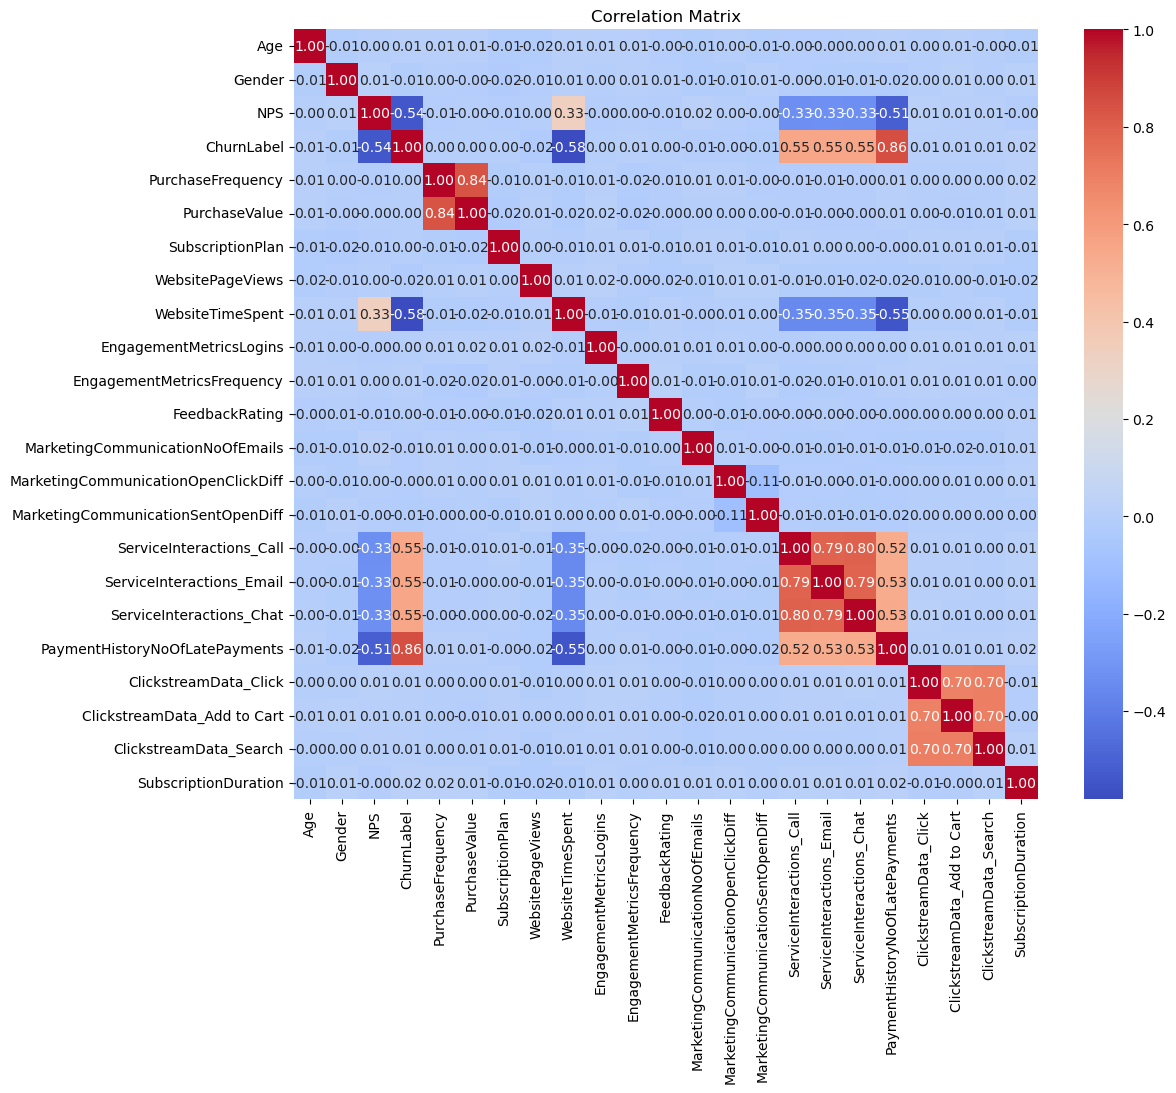

In [16]:
# plot correlation matrix
df_temp = df_.copy()
df_temp.drop(columns=['FirstInteractionDate', 'LastInteractionDate'], inplace=True)

df_corr = df_temp.corr()
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(df_corr, annot=True, fmt='.2f', cmap='coolwarm', ax=ax)
plt.title('Correlation Matrix')
plt.show()

**From the correlation graph above, the following features have a relationship with the ChurnLabel. These relationships are:**
- NPS: This has a modertae negative correlation (-0.54) with ChurnLabel 
- WebsiteTimeSpent: This has a moderate negative correlation (-0.56) with ChurnLabel
- Num_Call has moderate postive correlation (0.55) with ChurnLabel,
- Num_Email has moderate positive correlation (0.55) with ChurnLabel,
- Num_Chat has moderate positive correlation (0.55) with ChurnLabel,
- PaymentHistoryNoOfLatePayments shows high positive correlation (0.86) with ChurnLabel

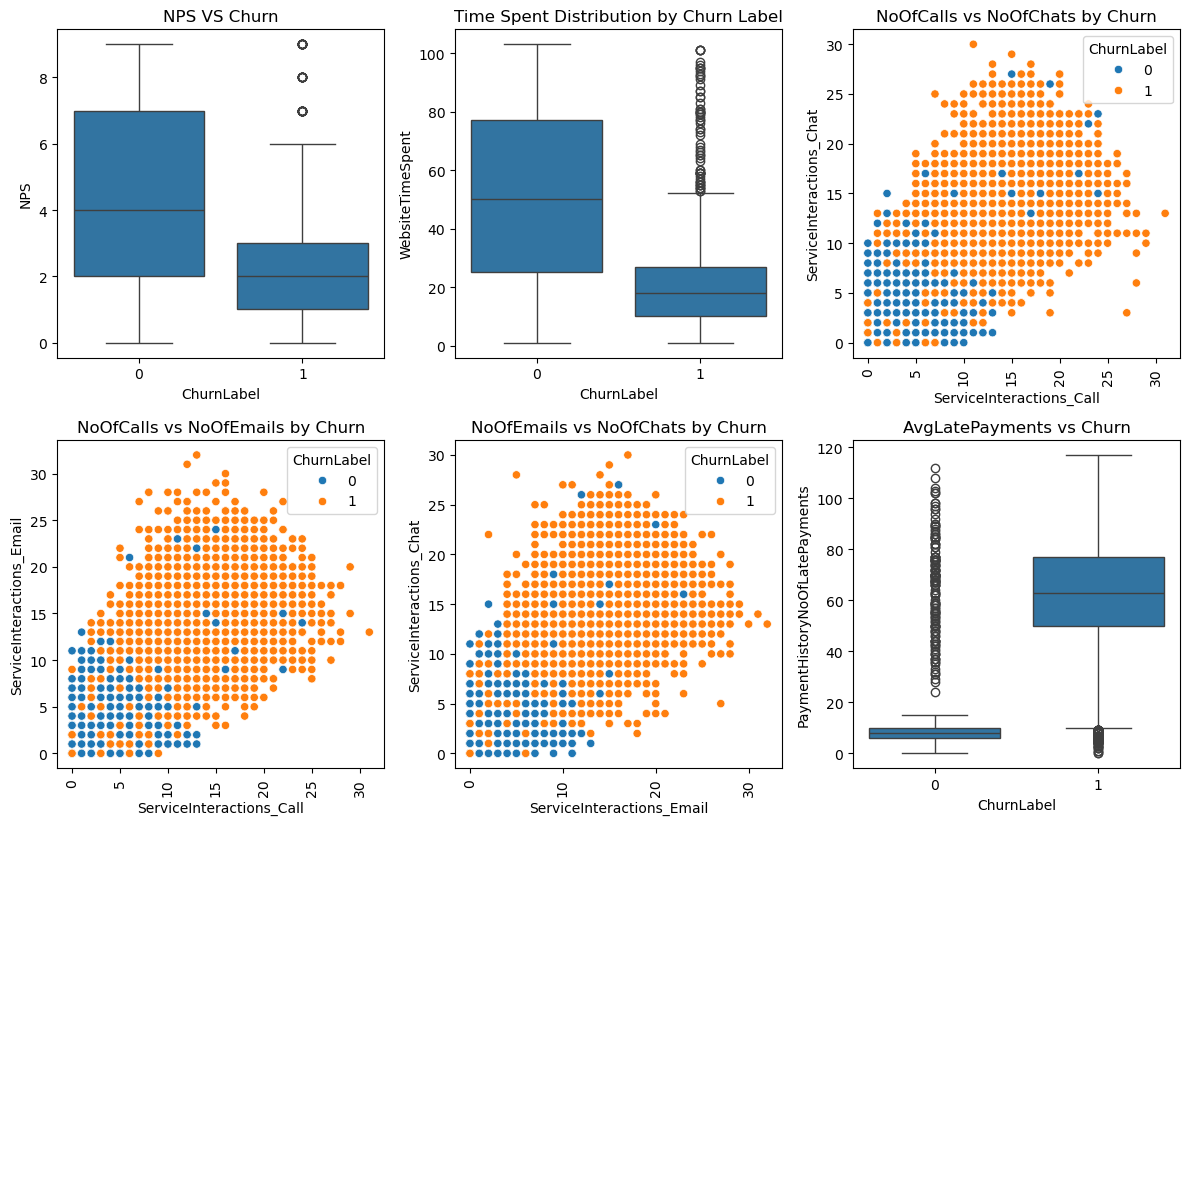

In [17]:
# To show the graphical representation of the above features with ChurnLabel
# Create 3x3 subplots
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))

# Plot 1: NPS VS Churn
sns.boxplot(data=df_, x="ChurnLabel", y="NPS", ax=ax[0, 0])
ax[0, 0].set_title('NPS VS Churn')

# Plot 2: TimeSpent VS Churn
sns.boxplot(data=df_, x='ChurnLabel', y='WebsiteTimeSpent', ax=ax[0, 1])
ax[0, 1].set_title('Time Spent Distribution by Churn Label')

# Plot 3: NoOfCalls vs NoOfChats
sns.scatterplot(data=df_, x='ServiceInteractions_Call', y='ServiceInteractions_Chat', hue='ChurnLabel', ax=ax[0, 2])
ax[0, 2].set_title('NoOfCalls vs NoOfChats by Churn')
ax[0, 2].tick_params(axis='x', rotation=90)

# Plot 4: NoOfCalls vs NoOfEmails
sns.scatterplot(data=df_, x='ServiceInteractions_Call', y='ServiceInteractions_Email', hue='ChurnLabel', ax=ax[1, 0])
ax[1, 0].set_title('NoOfCalls vs NoOfEmails by Churn')
ax[1, 0].tick_params(axis='x', rotation=90)

# Plot 5: NoOfEmails vs NoOfChats
sns.scatterplot(data=df_, x='ServiceInteractions_Email', y='ServiceInteractions_Chat', hue='ChurnLabel', ax=ax[1, 1])
ax[1, 1].set_title('NoOfEmails vs NoOfChats by Churn')
ax[1, 1].tick_params(axis='x', rotation=90)

# Plot 6: AVGLatePayment vs Churn
sns.boxplot(data=df_, x='ChurnLabel', y='PaymentHistoryNoOfLatePayments', ax=ax[1, 2])
ax[1, 2].set_title('AvgLatePayments vs Churn')

# Turn off unused subplots
for i in range(2, 3):
    for j in range(3):
        ax[i, j].axis('off')

plt.tight_layout()
plt.show()

**Key Insights from Visual Analysis:**

- Net Promoter Score (NPS) and Churn
Customers with a high NPS (score close to 10) are generally less likely to churn. The boxplot shows that most churned customers have a lower NPS, but there are still a few exceptions where customers with a high NPS have churned.

- Time Spent on Platform and Churn
Users who spend more time on the platform typically show lower churn rates. Churned users tend to have significantly less engagement time. Nonetheless, a few high-engagement users still chose to leave, indicating that time spent alone is not a guaranteed predictor.

- Service Interactions and Churn
The scatter plots reveal a pattern where customers who have more service interactions are more likely to churn. Orange dots (churned users) dominate the upper-right regions of the plots, suggesting that high interaction frequency may signal dissatisfaction or unresolved issues.

- Late Payments and Churn
There’s a clear trend indicating that customers with a high number of late payments are more likely to churn. The distribution of late payments for churned users is significantly higher, though a minority of users with frequent late payments still remain.

**Recommendation**

To mitigate churn risk, the organization should implement proactive retention strategies targeting customers with:

- Low NPS

- Short platform engagement time

- High volume of service interactions (calls, chats, emails)

- Frequent late payments

These behavioral signals can help prioritize at-risk users for outreach and support before they churn.

#### **RFM Analysis: Customer Segmentation based on these 3 categories - Recency, Frequency and Monetary value Customer Categories**

- Premium
- Loyal
- Regular
- At Risk
- Lost
Below is the function to perform the RFM

In [18]:
# Create function to perform RFM
def calculate_interaction_rfm(df_):
    # convert to datetime
    df_['LastInteractionDate'] = pd.to_datetime(df_['LastInteractionDate'])

    # get the current date assuming it is the last date on the lastinteraction date column
    current_date = df_['LastInteractionDate'].max()

    # calculate the recency, frequency and monetary value component
    
    # calculating recency: days since last purchase
    df_['recency'] = (current_date - df_['LastInteractionDate']).dt.days
    # calculating frequency: Interaction rate (interactions + logins)
    df_['frequency'] = df_['PurchaseFrequency'] * df_['EngagementMetricsLogins']
    # calculating monetary: Total purchase value
    df_['monetary'] = df_['PurchaseValue']
    
    # we have these 3 values, now we create rfm_score range labels
    r_label = range(5, 0, -1)
    f_label = range(1, 6)
    m_label = range(1, 6)
    
    # assigning these labels to the different distributions of the recency, frequency and monetary values
    df_['r_score'] = pd.qcut(df_['recency'], q =5, labels = r_label)
    df_['f_score'] = pd.qcut(df_['frequency'], q = 5, labels = f_label)
    df_['m_score'] = pd.qcut(df_['monetary'], q =5, labels = m_label)

    # suming up to get the rfm_score
    df_['rfm_score'] = (df_['r_score'].astype(int) + df_['f_score'].astype(int) + df_['m_score'].astype(int))

    # categorizing the customers
    bins = [0,5,9,13,16]
    labels= ['Lost', 'At_Risk', 'Loyal', 'Premium']
    df_['customer_segment'] = pd.cut(df_['rfm_score'], bins=bins, labels=labels)

    return df_
#call the function
data = calculate_interaction_rfm(df_)

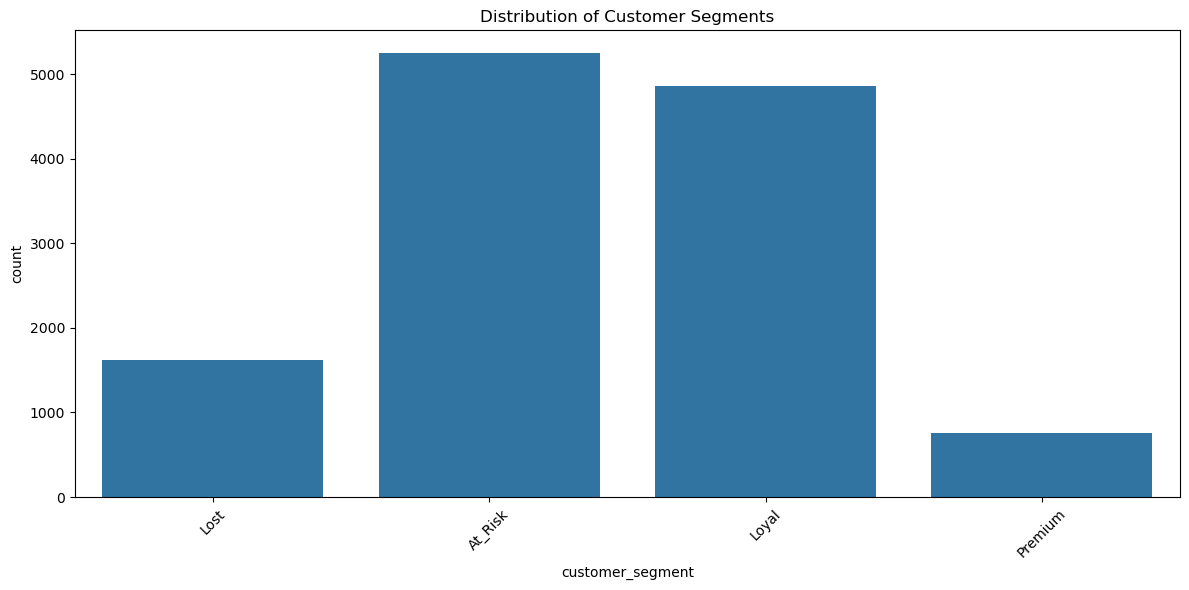

In [19]:
# visualizing the customer categories
plt.figure(figsize=(12, 6))

# Plot with ordered segments
sns.countplot(data=df_, x=df_['customer_segment'])        
plt.xticks(rotation=45)
plt.title('Distribution of Customer Segments')
plt.tight_layout()
plt.show()

Approximately 7,000 customers require attention:

- At_Risk Customers: These individuals need immediate engagement to prevent potential churn. A structured and proactive retention program should be implemented to address their concerns and reinforce loyalty.

- Lost Customers: Customers who have already churned should be contacted to gather feedback on their reasons for leaving. This insight will inform the development of a targeted reactivation strategy aimed at winning them back.

In [20]:
df_.to_csv('Model_dataset.csv', index=False)

Split data into train, test and validation sets

In [21]:
X = df_.drop(columns=['ChurnLabel','FirstInteractionDate', 'LastInteractionDate', 'customer_segment'])
y = df_['ChurnLabel']

# Split the dataset into training and testing sets
X_train, X_other, y_train, y_other = train_test_split(X, y, train_size=0.8, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_other, y_other, test_size=0.3, random_state=42)

In [22]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)
X_val = ss.transform(X_val)

#### **Feature Selection using Mutual Info Classif**

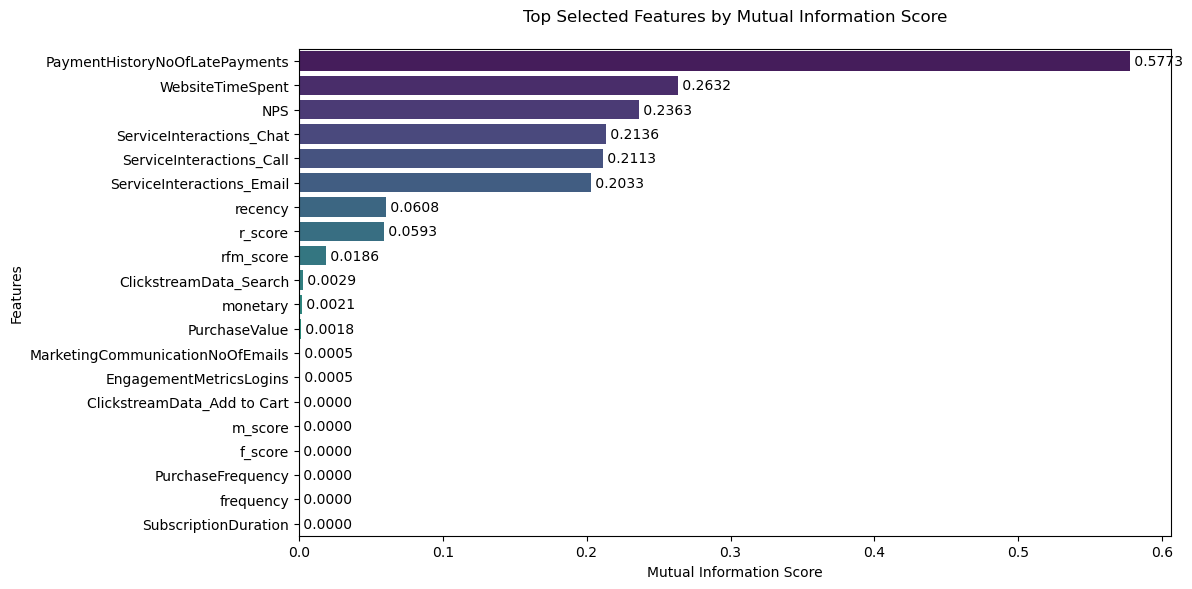

In [23]:
def select_features(X, y, n_features):
    selector = SelectKBest(score_func=mutual_info_classif, k=n_features)
    X_selected = selector.fit_transform(X, y)
    
    # Get selected feature names
    selected_features = X.columns[selector.get_support()].tolist()
    
    # Get scores for selected features
    feature_scores = pd.DataFrame({
        'Feature': X.columns,
        'Score': selector.scores_
    })
    feature_scores = feature_scores.sort_values('Score', ascending=False)
    
    # Create visualization
    plt.figure(figsize=(12, 6))
    
    # Plot feature importance scores
    sns.barplot(data=feature_scores.head(n_features), 
                x='Score', 
                y='Feature',
                palette='viridis')
    
    plt.title('Top Selected Features by Mutual Information Score', pad=20)
    plt.xlabel('Mutual Information Score')
    plt.ylabel('Features')
    
    # Add score values on bars
    for i, v in enumerate(feature_scores.head(n_features)['Score']):
        plt.text(v, i, f' {v:.4f}', va='center')
    
    plt.tight_layout()
    plt.show()
    
    return X_selected, selected_features, feature_scores

X_selected, selected_features, feature_scores = select_features(X, y, 20)

### Conclusion

Most important features:
- The number of service interactions the customer has had through call, email and chat
- The number of times a customer has made late payment
- The time spent on a company's website
- The Net Promoter Score (NPS)